# Dogs vs. Cats with Tensorflow and Python

![](data/woof_meow.jpg)

I have chosen the Dogs vs. Cats data set from the popular Kaggle competition for the small demo.

For traditional ML this is a difficult problem, there is so much overlap between cats and dogs being colour, texture and shape. For Deep Learning this is a fairly simple problem, the cutting edge models obtains a 97% accuracy, and my toy model for the purpose of showing you some code obtains a 90% accuracy.

## Dependencies

In [ ]:
%matplotlib inline
import matplotlib

import os
from skimage import color, io
from scipy.misc import imresize, imsave
from glob import glob
import random as rnd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches  

from sklearn.model_selection import train_test_split

## Helper methods

In [ ]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
def save_img(file_name):
    plt.savefig(file_name, format='png', dpi=300)

In [ ]:
def fetch_batch(X, iteration, batch_size):
    i = iteration * batch_size
    j = iteration * batch_size + batch_size
    return X[i:j]

## Preprocess the labeled data

In [ ]:
data_path = './data/train'
image_size = 128

cat_files_path = os.path.join(data_path + '/cats', 'cat.*.jpg')
dog_files_path = os.path.join(data_path + '/dogs', 'dog.*.jpg')

cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

file_count = len(cat_files) + len(dog_files)
print('Dog files found: {}'.format(len(dog_files)))
print('Cat files found: {}'.format(len(cat_files)))
file_count = 400

images = np.zeros((file_count, image_size, image_size, 3), dtype='float64')
labels = np.zeros(file_count)
count = 0
for f in cat_files[:200]:
    try:
        img = io.imread(f)
        new_img = imresize(img, (image_size, image_size, 3))
        new_img = np.array(new_img) / 255.
        images[count] = new_img
        labels[count] = 0
        count += 1
    except:
        continue

for f in dog_files[:200]:
    try:
        img = io.imread(f)
        new_img = imresize(img, (image_size, image_size, 3))
        new_img = np.array(new_img) / 255.
        images[count] = np.array(new_img)
        labels[count] = 1
        count += 1
    except:
        continue
        


In [ ]:
images.shape

In [ ]:
labels.shape

## Data insights

In [ ]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

for num,img_data in enumerate(images[0:25]):
    sub = fig.add_subplot(5,5,num+1)
    sub.imshow(img_data)
    #plt.title('cat', fontsize=18)
    sub.axes.get_xaxis().set_visible(False)
    sub.axes.get_yaxis().set_visible(False)
plt.show()


## Convolutions

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

img = io.imread('data/building.jpg')
img = img[150:280, 150:280]
new_img = imresize(img, (image_size, image_size, 3))
new_img = np.array(new_img) / 255.

plt.imshow(new_img)
plt.show()

In [ ]:
height, width, channels = new_img.shape
img_gray = new_img.mean(axis=2).astype(np.float32)
img_gray2 = img_gray.reshape(1, height, width, 1)

plt.imshow(img_gray)
plt.show()

In [ ]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plt.imshow(fmap[:, :, 0, 0])
plt.show()
plt.imshow(fmap[:, :, 0, 1])
plt.show()

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [ ]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: img_gray2})

### Vertical

In [ ]:
plt.imshow(output[0, :, :, 0])
plt.show()
#imsave('data/vertical.png', output[0, :, :, 0])

### Horizontal

In [ ]:
plt.imshow(output[0, :, :, 1])
plt.show()
#imsave('data/horizontal.png', output[0, :, :, 1])

## Train

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
X_test.shape

### The Model

In [ ]:
def conv_maxpool(inputs, num_filters=32, name='conv-maxpool'):
    with tf.name_scope(name):
        conv = tf.layers.conv2d(
            inputs=inputs,
            filters=num_filters,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)

        pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        return pool

In [ ]:
with tf.name_scope('placeholders'):
        with tf.name_scope('X'):
            X = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name="X")
        with tf.name_scope('y'):
            y = tf.placeholder(tf.int32, shape=[None], name="y")

In [ ]:
with tf.name_scope('model'):
        convmax1 = conv_maxpool(inputs=X, num_filters=32, name='conv-max-1')
        convmax2 = conv_maxpool(inputs=convmax1, num_filters=64, name='conv-max-2')
        convmax3 = conv_maxpool(inputs=convmax2, num_filters=128, name='conv-max-3')
        convmax4 = conv_maxpool(inputs=convmax3, num_filters=128, name='conv-max-4')

        with tf.name_scope('flat'):
            pool_flat = tf.reshape(convmax4, shape=[-1, 128 * 8 * 8])

        with tf.name_scope('fc-1'):
            dense = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
        with tf.name_scope('drop-out-1'):
            dropout = tf.layers.dropout(inputs=dense, rate=0.5)

        # Logits Layer
        with tf.name_scope('logits-1'):
            logits = tf.layers.dense(inputs=dropout, units=2)

In [ ]:
with tf.name_scope('ops-1'):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)

In [ ]:
with tf.name_scope('summary'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

1-20 Train acc: 0.5 Val acc: 0.30000001192092896
... save new best model
2-40 Train acc: 0.4000000059604645 Val acc: 0.30000001192092896
3-60 Train acc: 0.4000000059604645 Val acc: 0.7000000476837158
... save new best model
4-80 Train acc: 0.6000000238418579 Val acc: 0.30000001192092896
5-100 Train acc: 0.7000000476837158 Val acc: 0.44999998807907104
7-120 Train acc: 0.550000011920929 Val acc: 0.7000000476837158
8-140 Train acc: 0.949999988079071 Val acc: 0.8500000238418579
... save new best model
9-160 Train acc: 0.949999988079071 Val acc: 0.75
10-180 Train acc: 0.8500000238418579 Val acc: 0.550000011920929
11-200 Train acc: 1.0 Val acc: 0.75
12-220 Train acc: 0.800000011920929 Val acc: 0.4000000059604645
14-240 Train acc: 0.949999988079071 Val acc: 0.6500000357627869
15-260 Train acc: 0.949999988079071 Val acc: 0.7000000476837158
16-280 Train acc: 0.949999988079071 Val acc: 0.800000011920929
17-300 Train acc: 1.0 Val acc: 0.6000000238418579
18-320 Train acc: 0.949999988079071 Val acc

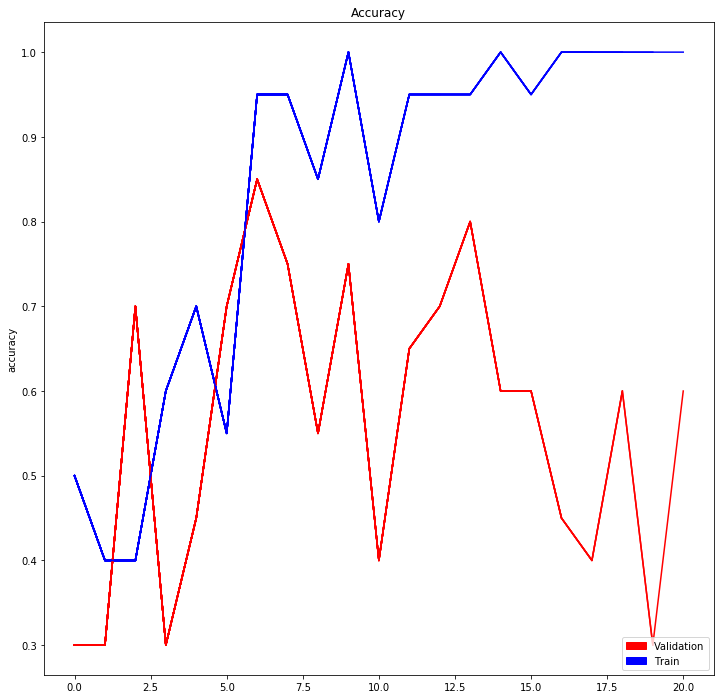

In [31]:
step = 0
prev_best = 0
num_epochs = 25
batch_size = 20
train_accs = []
_val_accs = []
train_loss = []
val_loss = []
plt.ion()
plt.show()
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)
feedback_step = 0

with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        for i in range(len(X_train) // batch_size):
            X_train_batch = fetch_batch(X_train, i, batch_size)
            Y_train_batch = fetch_batch(Y_train, i, batch_size)
            
            sess.run(training_op, feed_dict={X: X_train_batch, y: Y_train_batch})

            step += 1
            val_accs = []
            if step % 20 == 0:    
                feedback_step += 1
                val_accs[:] = []

                for j in range(len(X_val) // batch_size):
                    X_val_batch = fetch_batch(X_val, j, batch_size)
                    y_val_batch = fetch_batch(y_val, j, batch_size)

                    val_acc = sess.run(accuracy, feed_dict={X:X_val_batch, y: y_val_batch})
                    val_accs.append(val_acc)

                temp_acc = sum(val_accs)/len(val_accs)
                train_acc = sess.run(accuracy, feed_dict={X:X_train_batch, y: Y_train_batch})
                
                # Pyplot
                train_accs.append(train_acc)
                _val_accs.append(temp_acc)
                
                steps = [x for x in range(feedback_step)]
                plt.subplot(1, 1, 1)
                plt.title('Accuracy')
                plt.plot(steps, _val_accs, color='r')
                plt.plot(steps, train_accs, color='b')
                plt.ylabel('accuracy')
                
                red_patch = mpatches.Patch(color='red', label='Validation')
                blue_patch = mpatches.Patch(color='blue', label='Train')

                plt.legend(handles=[red_patch, blue_patch], loc=4)

                print('{}-{} Train acc: {} Val acc: {}'.format(epoch, step, train_acc, temp_acc))
                if temp_acc > prev_best:
                    print('... save new best model')
                    prev_best = temp_acc
                    save_path = saver.save(sess, "models/model-{}-{:2.2f}.ckpt".format(epoch, temp_acc))
    plt.savefig('./data/training_acc.png')

## Measure against unseen test set

In [ ]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, './models/model-2-0.64.ckpt')